# 1. 简单介绍
本文的应用场景多输入问题，采用的数据集为有，'black_jeans', 'black_shoes','blue_dress','blue_jeans','blue_shirt','red_dress','red_shirt'七个类别，我们将根据颜色和衣服类型进行两类输出

# 2. 加载相关数据包

In [41]:
import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib
import os
import random

Tensorflow version: 2.0.0


## 2.1 图片的路径的配置

In [2]:
#配置数据集路径
path_root = os.path.realpath(".")
data_dir = pathlib.Path(path_root)

#数量构成
image_count = len(list(data_dir.glob('dataset/*/*.jpg')))
label_names = sorted(item.name for item in data_dir.glob("dataset/*"))
#图片路径
all_image_path = list(list(data_dir.glob('dataset/*/*.jpg')))    
#将路径打乱
all_image_path = [str(path) for path in all_image_path]
random.shuffle(all_image_path)


color_label_names = set(name.split('_')[0] for name in label_names)
item_label_names = set(name.split('_')[1] for name in label_names)

color_lable_to_index = dict((name,index) for index,name in enumerate(color_label_names))
item_lable_to_index = dict((name,index) for index,name in enumerate(item_label_names))

color_label = [color_lable_to_index[pathlib.Path(path).parent.name.split("_")[0]] for path in all_image_path]
item_label = [item_lable_to_index[pathlib.Path(path).parent.name.split("_")[1]] for path in all_image_path]

In [3]:
color_lable_to_index

{'red': 0, 'black': 1, 'blue': 2}

## 2.2 读取图片

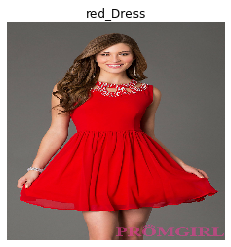

In [27]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image /= 255.0  # normalize to [0,1] range
    image = 2*image-1
    return image


#加载图片
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

#举例
image_path = all_image_path[11]
color = color_label[11]
item = item_label[11]

plt.imshow((load_and_preprocess_image(image_path)+1)/2)
plt.grid(False)
##plt.xlabel(caption_image(image_path))
plt.title(str(list(color_lable_to_index.keys())[color])+"_"+str(list(item_lable_to_index.keys())[item]).title())
plt.axis("off")
plt.show()

# 3. 图片预处理
在这一部分我们采用from_tensor_slices的方法对图片数据集进行构建，对比tf1.x版本采用队列形式读取数据，这一种方法比较简单切易于理解。并构建（图片，标签）对数据集。

In [5]:
#%%构建一个tf.data.Dataset
#一个图片数据集构建 tf.data.Dataset 最简单的方法就是使用 from_tensor_slices 方法。
#将字符串数组切片，得到一个字符串数据集：
path_ds =  tf.data.Dataset.from_tensor_slices(all_image_path)
print(path_ds)
#现在创建一个新的数据集，通过在路径数据集上映射 preprocess_image 来动态加载和格式化图片。
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)

lable_ds = tf.data.Dataset.from_tensor_slices((color_label, item_label))
for color,item in lable_ds.take(5):
    print(str(list(color_lable_to_index.keys())[color])+"_"+str(list(item_lable_to_index.keys())[item]))
#%%构建一个（图片，标签）对数据集
#因为这些数据集顺序相同，可以将他们打包起来
image_label_ds = tf.data.Dataset.zip((image_ds,lable_ds))
print(image_label_ds)

<TensorSliceDataset shapes: (), types: tf.string>
blue_dress
blue_dress
blue_shirt
red_dress
blue_shirt
<ZipDataset shapes: ((224, 224, 3), ((), ())), types: (tf.float32, (tf.int32, tf.int32))>


# 4. 训练阶段
## 4.1 设置验证集与数据集

In [6]:
#%%设置训练数据和验证集数据的大小
test_count = int(image_count*0.2)
train_count = image_count - test_count
print(test_count,train_count)
#跳过test_count个
train_dataset = image_label_ds.skip(test_count)
test_dataset = image_label_ds.take(test_count)

batch_size = 16
# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据被充分打乱。
train_ds = train_dataset.shuffle(buffer_size=train_count).repeat().batch(batch_size)
test_ds = test_dataset.batch(batch_size)


419 1677


## 4.2 构建模型并训练

In [7]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), 
                                               include_top=False,
                                               weights='imagenet')

mobile_net.trianable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = mobile_net(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x1 = tf.keras.layers.Dense(1024, activation='relu')(x)
out_color = tf.keras.layers.Dense(len(color_label_names), 
                                  activation='softmax',
                                  name='out_color')(x1)

x2 = tf.keras.layers.Dense(1024, activation='relu')(x)
out_item = tf.keras.layers.Dense(len(item_label_names), 
                                 activation='softmax',
                                 name='out_item')(x2)
model = tf.keras.Model(inputs=inputs,
                       outputs=[out_color, out_item])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    (None, 7, 7, 1280)   2257984     input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           mobilenetv2_1.00_224[1][0]       
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         1311744     global_average_pooling2d[0][0]   
______________________________________________________________________________________________

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss={'out_color':'sparse_categorical_crossentropy',
                    'out_item':'sparse_categorical_crossentropy'},
              metrics=['acc']
)

In [9]:
steps_per_eooch = train_count//batch_size
validation_steps = test_count//batch_size

history = model.fit(train_ds,epochs=3,steps_per_epoch=steps_per_eooch,validation_data=test_ds,validation_steps=validation_steps)

Train for 104 steps, validate for 26 steps
Epoch 1/3
104/104 [==============================] - 103s 991ms/step - loss: 0.4240 - out_color_loss: 0.2223 - out_item_loss: 0.2017 - out_color_acc: 0.9123 - out_item_acc: 0.9399 - val_loss: 0.1177 - val_out_color_loss: 0.0892 - val_out_item_loss: 0.0284 - val_out_color_acc: 0.9688 - val_out_item_acc: 0.9880
Epoch 2/3
104/104 [==============================] - 86s 825ms/step - loss: 0.0716 - out_color_loss: 0.0404 - out_item_loss: 0.0312 - out_color_acc: 0.9838 - out_item_acc: 0.9916 - val_loss: 0.0842 - val_out_color_loss: 0.0412 - val_out_item_loss: 0.0430 - val_out_color_acc: 0.9856 - val_out_item_acc: 0.9880
Epoch 3/3
104/104 [==============================] - 87s 833ms/step - loss: 0.0416 - out_color_loss: 0.0170 - out_item_loss: 0.0246 - out_color_acc: 0.9952 - out_item_acc: 0.9922 - val_loss: 0.0546 - val_out_color_loss: 0.0309 - val_out_item_loss: 0.0238 - val_out_color_acc: 0.9904 - val_out_item_acc: 0.9904


# 5. 模型评估

In [11]:
model.evaluate(test_ds)

27/27 [==============================] - 9s 347ms/step - loss: 0.0526 - out_color_loss: 0.0297 - out_item_loss: 0.0229 - out_color_acc: 0.9905 - out_item_acc: 0.9905


[0.052628928653171494, 0.02974791, 0.022881018, 0.9904535, 0.9904535]

我们在网上找一个图片，检验其准确性

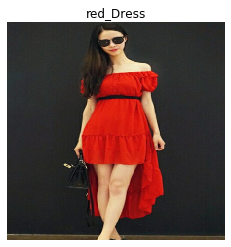

In [39]:
str(list(data_dir.glob('dataset/*.jpg'))[0])
my_image = load_and_preprocess_image(str(list(data_dir.glob('dataset/*.jpg'))[0]))
my_image = tf.expand_dims(my_image, 0)
pred = model.predict(my_image)
plt.grid(False)
plt.imshow((tf.squeeze(my_image,axis=0)+1)/2)
plt.title(str(list(color_lable_to_index.keys())[np.argmax(pred[0])])+"_"+str(list(item_lable_to_index.keys())[np.argmax(pred[1])]).title())
plt.axis("off")
plt.show()

In [40]:
label_names

['black_jeans',
 'black_shoes',
 'blue_dress',
 'blue_jeans',
 'blue_shirt',
 'red_dress',
 'red_shirt']